In [20]:
import numpy as np
import matplotlib.pyplot as plt

class lattice(): #class that describes a crystal lattice , from Dr Alberto's lattice_utils.py file
    
    def __init__(self,a, b , c , alpha = 90 , beta = 90 , gamma = 90): # a,b,c lattice parameters in armstrong; alpha , beta , gamma in degrees 
        
        self.a = a
        self.b = b 
        self.c = c
        self.alpha = alpha*np.pi/180
        self.beta = beta*np.pi/180
        self.gamma = gamma*np.pi/180
        
        self.lvec = [a,b,c,self.alpha , self.beta,self.gamma] #lattice vector array
        
        self.gtensor()

    def gtensor(self): #function that calculates g tensor of a lattice from Dr Alberto's lattice_utils.py file
        
        g = np.empty([3,3])
        
        g[0,0] = self.a**2
        g[0,1] = self.a*self.b*np.cos(self.gamma)
        g[0,2] = self.a*self.c*np.cos(self.beta)
        
        g[1,0] = g[0,1]
        g[1,1] = self.b**2
        g[1,2] = self.c*self.b*np.cos(self.alpha)
        
        g[2,0] = g[0,2] 
        g[2,1] = g[1,2]
        g[2,2] = self.c**2
        
        self.gtensor = g
        
    def recip_lattice(self): 
        
        '''
        function by Dr Alberto that calculates the reciprocal of a lattice 
        '''
        
        a_vect = np.array([self.a,0,0])
        b_vect = np.array([self.b*np.cos(self.gamma) ,self.b*np.sin(self.gamma) ,0])
        c_vect = np.array([self.c*np.cos(self.alpha) , self.c*np.sin(self.beta) , np.sqrt(self.c**2*(1-(np.cos(self.alpha))**2 + (np.cos(self.beta)**2)))])
        
        vol = np.sum(a_vect*np.cross(b_vect , c_vect))
        
        a_star = 2*np.pi*self.b*self.c*np.sin(self.alpha)/vol
        b_star = 2*np.pi*self.a*self.c*np.sin(self.beta)/vol
        c_star = 2*np.pi*self.a*self.b*np.sin(self.gamma)/vol
        
        alpha_star = np.arccos((np.cos(self.beta)*np.cos(self.gamma)-np.cos(self.alpha))/(np.sin(self.beta)*np.sin(self.gamma)))
        beta_star = np.arccos((np.cos(self.alpha)*np.cos(self.gamma)-np.cos(self.beta))/(np.sin(self.alpha)*np.sin(self.gamma)))
        gamma_star = np.arccos((np.cos(self.alpha)*np.cos(self.beta)-np.cos(self.gamma))/(np.sin(self.alpha)*np.sin(self.beta)))
        
        alpha_new = np.rad2deg(alpha_star)
        beta_new = np.rad2deg(beta_star)
        gamma_new = np.rad2deg(gamma_star)
        
        self.rlatt = lattice(a_star , b_star , c_star , alpha_new , beta_new , gamma_new)
        


        

In [21]:
        
class VectorOps(): #class with methods for vector operations
    
    @staticmethod
    def vector(v1 , v2 , latt): 
        
        '''
        function by Dr Alberto that calculates prodct of two vectors given by its miller indice
        '''
        
        u = (v1[1]*v2[2] - v2[1]*v1[2])
        v = (v1[2]*v2[0] - v2[2]*v1[0])
        w = (v1[0]*v2[1] - v2[0]*v1[1])

        new_vector = Miller([u,v,w] , latt)

        return new_vector
    
    @staticmethod
    def Miller(V,latt):
        
        '''
        function by Dr Alberto that calculates miller indice of a vector 
        '''
        
        g = latt.gtensor
        
        h = (g[0,0]*V[0] + g[1,0]*V[1] + g[2,0]*V[2])/(2.*np.pi)
        k = (g[0,1]*V[0] + g[1,1]*V[1] + g[2,1]*V[2])/(2.*np.pi)
        l = (g[0,2]*V[0] + g[1,2]*V[1] + g[2,2]*V[2])/(2.*np.pi)
        
        return [h,k,l]
    
        
    @staticmethod
    def scalar(v1 , v2 , latt):
        
        '''
        function by Dr Alberto that calculates the scalar product of 2 vectors given by its miller indice
        '''
        
        s1 = v1[0]*v2[0]*latt.a**2 + v1[1]*v2[1]*latt.b*2 + v1[2]*v2[2]*latt.c**2
        s2 = (v1[0]*v2[1] + v2[0]*v1[1])*latt.a*latt.b*np.cos(latt.gamma)
        s3 = (v1[0]*v2[2] + v1[2]*v2[0])*latt.a*latt.c*np.cos(latt.beta)
        s4 = (v1[1]*v2[2] + v2[2]*v1[1])*latt.c*latt.b*np.cos(latt.alpha)
        
        s = s1+s2+s3+s3
        
        return s
    
    @staticmethod
    def modVec(v1 , latt):
        
        '''
        function by Dr Alberto that calculates magnitude of a vector given by its miller indice
        '''
        
        mod = np.sqrt(VectorOps.scalar(v1 , v1 , latt))
        
        return mod
    
    @staticmethod
    def dspacing(v1 , r_latt):
        
        '''
        function by Dr Alberto that calculates d spacing to a given set of miller indices arguments
        '''
        
        d = 2*np.pi/VectorOps.modVec(v1,r_latt)
        
        return d

In [22]:
import matplotlib.pyplot as plt

class PowderDiffraction():
    
    def __init__(self ,latt:lattice,wavelength,type_,atomic_scattering_factors:list):
        
        self.latt = latt
        self.FCC_PEAKS =[[1,1,1],[2,0,0],[2,2,0],[3,1,1],[2,2,2],[4,0,0],[3,3,1],[4,2,0],
            [4,2,2],[5,1,1],[3,3,3],[4,4,0],[5,3,1],[4,4,2],[6,0,0]]
    
        self.FCC_M_FACTORS = [8,6,12,24,8]
        self.type_ = type_
        self.tth2_list = []
        self.modQ = []
        self.h = []
        self.k = []
        self.l = []
        self.wavelength = wavelength
        self.I_list = []
        self.ASF = atomic_scattering_factors
        self.F_list = []
        self.D_list = []
        
    def Calculate(self):
        
        self.FindPeaks()
        
        for peak in self.peaks:
            
            self.modQ.append(VectorOps.modVec(peak , self.latt))
            current_disp = VectorOps.dspacing(peak , self.latt)
            
            tth2 = 2*(360/np.pi)*np.arcsin((self.wavelength/2)/(2*current_disp))
            
            asf = self.CalculateASF(tth2/2)
            
            f = PowderDiffraction.CalculateF(peak , asf)
            
            self.F_list.append(f)
            
            I = PowderDiffraction.CalculateIntensity(peak , tth2 , asf )
            
            #print(asf)
            
            self.tth2_list.append(tth2)
            self.I_list.append(I)
            self.h.append(peak[0])
            self.k.append(peak[1])
            self.l.append(peak[2])
            self.D_list.append(current_disp)
        
        max_i = max(self.I_list)
        
        self.RI_list = []
        
        
        for i in range(len(self.tth2_list)):
            
            self.tth2_list[i] = round(self.tth2_list[i])
        
        
        self.tth2_list_all = np.arange(0 , 120,0.1)
        self.I_list_all = []
        
        for i in self.tth2_list_all:
            
            if i in self.tth2_list:
                
                index = 0
                
                for j in range(len(self.tth2_list)):
                    
                    if self.tth2_list[j] == i:
                        
                        index = j
                        
                self.I_list_all.append(self.I_list[index])

            else:
                
                self.I_list_all.append(0)
        
        for i in self.I_list_all:
            
            self.RI_list.append((i/max_i)*100)
            
    
    @staticmethod
    def CalculateF(peak , asf):
        
        h,k,l = peak[0] , peak[1] , peak[2]
        
        if h%2!=k%2!=l%2:
            
            return 0 
        
        return 4*asf
    
    
    def CalculateASF(self,theta):
        
        index = round(np.sin(theta)/self.wavelength)
        
        if index > 10:
            
            index = 10
        
        return self.ASF[int(index)]
    
    @staticmethod
    def CalculateIntensity(peak , tth2,  asf):
        
        f = PowderDiffraction.CalculateF(peak ,asf)
        
        #I = f**2*(1+np.cos(tth2)**2)/(((np.sin(tth2/2))**2)*np.cos(tth2/2))
        I = f**4
        
        return np.abs(I)
        
    def FindPeaks(self):
        
        if self.type_ == 0:
            
            self.peaks = self.FCC_PEAKS
            self.m_factor = self.FCC_M_FACTORS
        
    def Display(self):
        
        plt.style.use('ggplot')

        plt.figure(figsize=(30,10))
            
        print("h   k    l    d     f      tth2     Ri")
        print("--------------------------------------")

        for i in range(len(self.peaks)):

            peak = self.peaks[i]
            h,k,l,f,I = peak[0],peak[1],peak[2],self.F_list[i], self.I_list[i]*100/max(self.I_list)
            print("{}   {}   {}  {:.2f}   {:.2f}    {:.2f}    {:.2f}".format(h,k,l,self.D_list[i],f,self.tth2_list[i],I))

        plt.plot(al_diff.tth2_list_all , al_diff.RI_list)
        plt.xlabel("2θ")
        plt.ylabel("Relative Intensity")
        plt.title("Relative Intesity over 2θ")
        
    
    

h   k    l    d     f      tth2     Ri
--------------------------------------
1   1   1  2.23   52.00    39.00    100.00
2   0   0  2.02   52.00    43.00    100.00
2   2   0  1.34   44.92    65.00    55.69
3   1   1  1.21   9.32    73.00    0.10
2   2   2  1.12   44.92    79.00    55.69
4   0   0  1.01   52.00    87.00    100.00
3   3   1  0.87   52.00    102.00    100.00
4   2   0  0.88   52.00    101.00    100.00
4   2   2  0.81   9.32    111.00    0.10
5   1   1  0.78   44.92    116.00    55.69
3   3   3  0.74   52.00    121.00    100.00
4   4   0  0.67   9.32    136.00    0.10
5   3   1  0.66   52.00    138.00    100.00
4   4   2  0.64   52.00    145.00    100.00
6   0   0  0.67   9.32    135.00    0.10


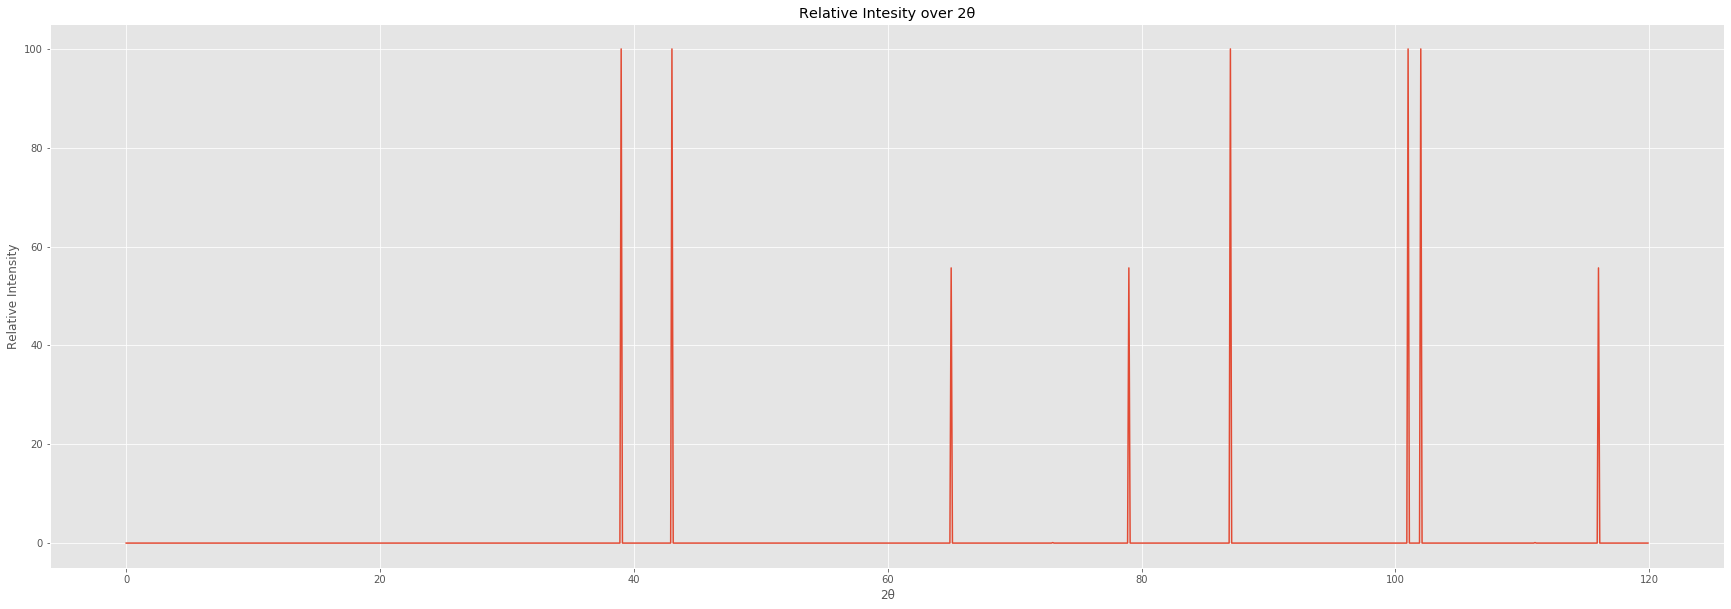

In [23]:

al_asf_list = [13,11.23,9.158,7.873,6.766,5.692,4.713,3.883,3.221,2.712,2.330]

al_lattice = lattice(4.0498,4.0498,4.0498)
al_lattice.recip_lattice()
al_diff = PowderDiffraction(al_lattice.rlatt ,1.5, 0 ,al_asf_list)
al_diff.Calculate()
al_diff.Display()

      h    k    l         d     F real    F imag      |F|         2θ  \
0   1.0  1.0  1.0  2.338026  34.994167  0.938368  35.0067   38.47254   
1   0.0  0.0  2.0  2.024790  32.777015  0.924171  32.7900   44.72098   
2   0.0  2.0  2.0  1.431743  26.666119  0.869500  26.6803   65.09698   
3   1.0  1.0  3.0  1.220994  23.237932  0.830630  23.2528   78.22962   
4   2.0  2.0  2.0  1.169013  22.224956  0.818063  22.2400   82.43646   
5   0.0  0.0  4.0  1.012395  18.691185  0.769669  18.7070   99.08112   
6   1.0  3.0  3.0  0.929037  16.497957  0.735262  16.5143  112.01975   
7   0.0  2.0  4.0  0.905514  15.840495  0.724138  15.8570  116.57000   
8   2.0  2.0  4.0  0.826617  13.524463  0.681300  13.5416  137.45521   
9   3.0  3.0  3.0  0.779342  12.069306  0.650843  12.0868  162.52395   
10  1.0  1.0  5.0  0.779342  12.069306  0.650843  12.0868  162.52395   

            I     M         RI  
0   100.00000   8.0  100.00000  
1    47.00894   6.0   47.00894  
2    26.71328  12.0   26.71328  
3  

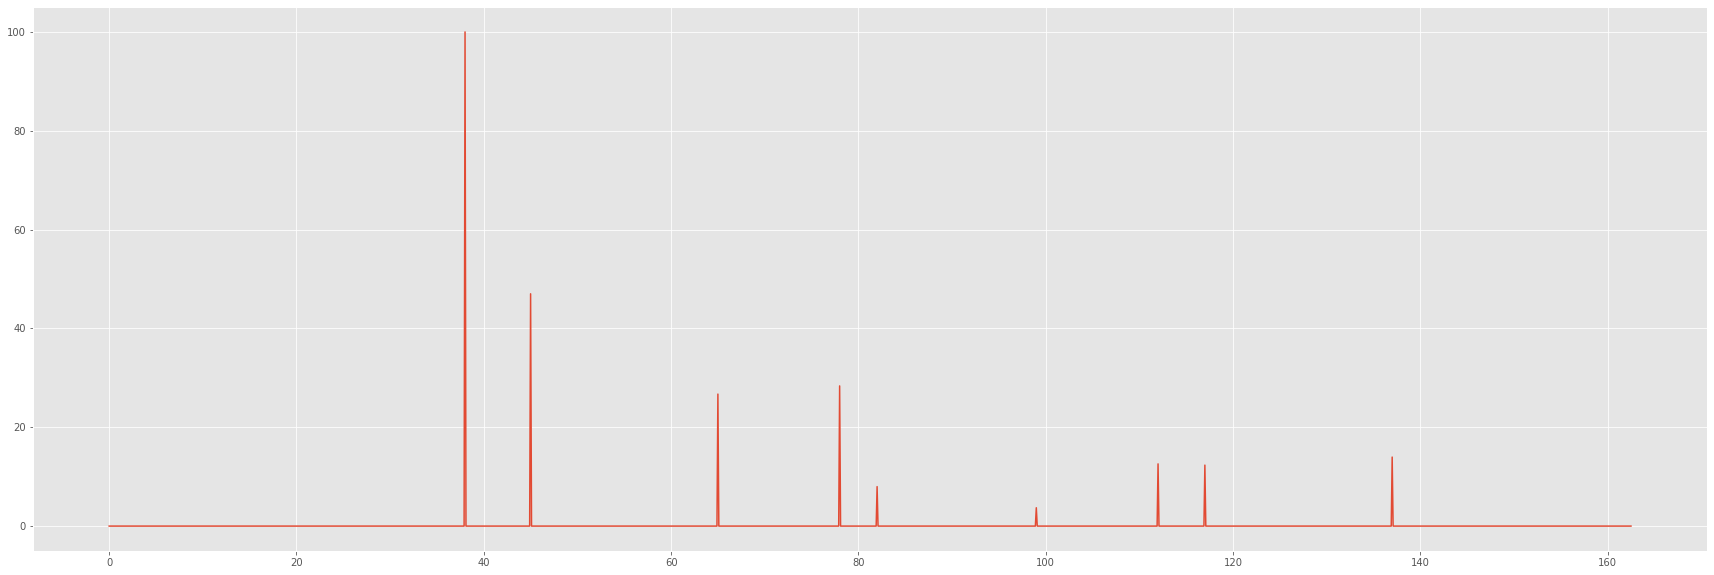

In [24]:
import pandas as pd

'''
class that converts data exported from vesta into plots and a pandas dataframe

'''

class VestaData():
    
    @staticmethod
    def Display(file_path):
        
        file = open(file_path , 'r')
        
        raw = []
        
        for row in file:
            
            raw.append(row)
            
        raw_data = raw[1:]
        
        data = []
        
        for i in raw_data:
            
            row = i.split(' ')
            list_indices = []
            
            for i in range(len(row)-1):
                
                if row[i] == '':
                    
                    list_indices.append(i)
                
                
            for i in range(len(list_indices)):
                    
                row.pop(list_indices[i]-i)
                    
            data.append(row)
        
        data_float = []
        
        for row in data[:-1]:
            
            row_float = [float(x) for x in row]
            
            data_float.append(row_float)
        
        #list(map(print , data_float))
        
        dataframe = pd.DataFrame(data_float)
        
        dataframe.columns = ["h" , "k" , "l" , "d" , "F real" , "F imag" , "|F|" , "2θ" , "I" , "M"]
        
        intensity = dataframe["I"]
        
        max_i = max(intensity)
        
        dataframe["RI"] = dataframe["I"]*100/max_i
        
        print(dataframe)
        
        tth2_list = list(dataframe["2θ"])
        RI_list = []
        
        for i in range(len(tth2_list)):
            
            tth2_list[i] = round(tth2_list[i])
        
        tth2_list_all = np.arange(0 , max(dataframe["2θ"]) ,0.1)
        
        for a in tth2_list_all:
            
            if a in tth2_list:
                
                index = 0
                
                for j in range(len(tth2_list)):
                    
                    if tth2_list[j] == a:
                        
                        index = j
                        
                RI_list.append(dataframe["RI"][index])

            else:
                
                RI_list.append(0)        
        
        plt.style.use('ggplot')
        plt.figure(figsize=(30,10))
        plt.plot(tth2_list_all , RI_list)
    
#aluminium vesta data plotting and printing

VestaData.Display("AMS_DATA.txt")

     h    k    l         d     F real     F imag           |F|         2θ  \
0  1.0  1.0  1.0  2.059408  11.510514 -11.442220  1.623010e+01   43.92970   
1  0.0  2.0  2.0  1.261125  13.513498   0.061904  1.351360e+01   75.29490   
2  1.0  1.0  3.0  1.075491   5.678188   5.736548  8.071540e+00   91.48782   
3  2.0  2.0  2.0  1.029704  -0.000000   0.000000  2.048840e-15   96.84789   
4  0.0  0.0  4.0  0.891750   9.374343   0.052899  9.374490e+00  119.49264   
5  1.0  3.0  3.0  0.818326   4.273126  -4.223255  6.007950e+00  140.54467   

           I     M         RI  
0  100.00000   8.0  100.00000  
1   32.01444  12.0   32.01444  
2   17.71939  24.0   17.71939  
3    0.00000   8.0    0.00000  
4    7.06466   6.0    7.06466  
5   18.74341  24.0   18.74341  


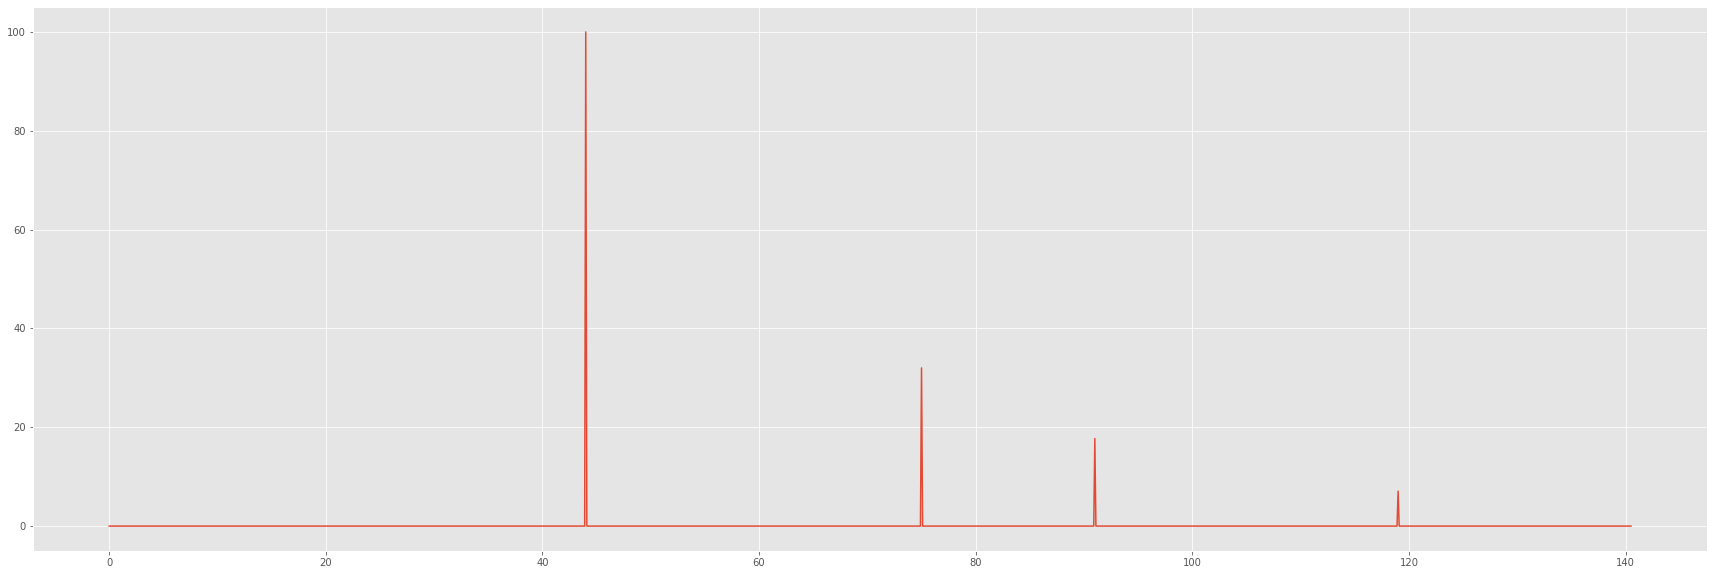

In [25]:

#DIAMOND DATA

VestaData.Display("DIAMOND_DATA.txt")